<a href="https://colab.research.google.com/github/ssarker21/Introduction-to-Machine-Learning/blob/main/Homework_7(Problem_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu


100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


ResNet10(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

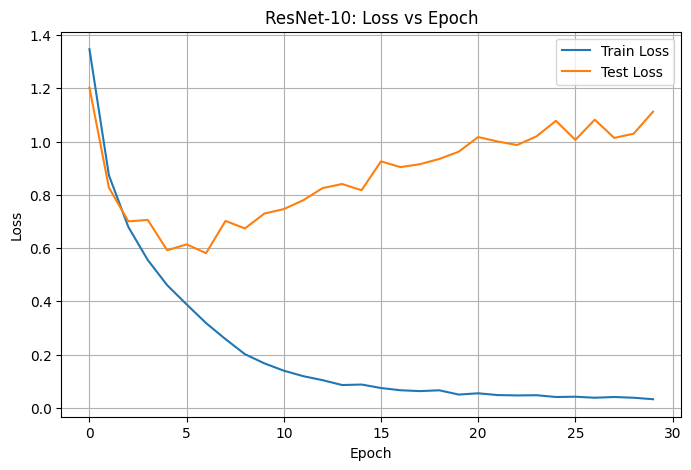

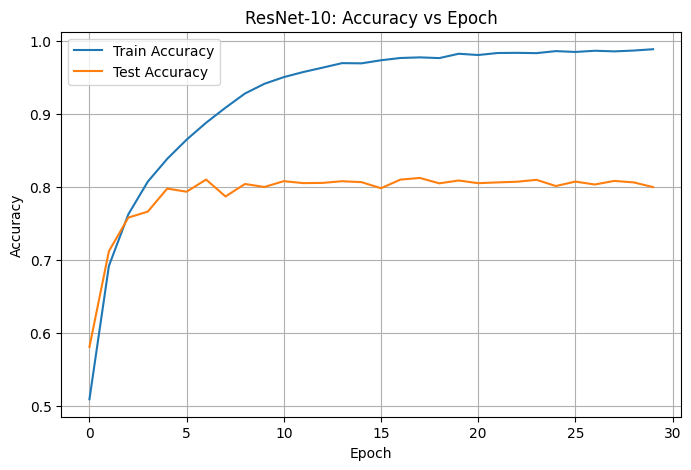

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

# ====================================================
# 1. Device Setup
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ====================================================
# 2. CIFAR-10: Transforms & Data Loaders
# ====================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4907, 0.4877, 0.4765],
        std=[0.2003, 0.1950, 0.2310]
    )
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0
)

class_names = train_dataset.classes

# ====================================================
# 3. ResNet Building Blocks
# ====================================================
class BasicBlock(nn.Module):
    """
    Classic ResNet Basic Block:
    conv3x3 -> BN -> ReLU -> conv3x3 -> BN + skip connection
    If in/out dims differ, use a 1x1 conv in the skip path.
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip / identity path
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # 1x1 conv to match shape
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Add skip connection
        out += self.shortcut(identity)
        out = F.relu(out)
        return out


class ResNet10(nn.Module):
    """
    ResNet-10 for CIFAR-10:
    - Initial conv
    - 4 stages with BasicBlocks
      blocks_per_stage = [2, 2, 3, 3] -> total = 10
    - Global average pooling + FC
    """
    def __init__(self, block=BasicBlock, num_blocks=[2, 2, 3, 3], num_classes=10):
        super(ResNet10, self).__init__()

        self.in_channels = 16

        # Initial stem: 3x3 conv, 16 channels (no maxpool for CIFAR)
        self.conv1 = nn.Conv2d(
            3, 16, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(16)

        # Residual stages
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)

        # Global Average Pooling + Fully Connected
        self.fc = nn.Linear(128 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Build one stage of the network with `num_blocks` residual blocks.
        First block may downsample using `stride`, rest use stride=1.
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for s in strides:
            layers.append(block(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial conv + BN + ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        # Residual stages
        out = self.layer1(out)   # 32x32
        out = self.layer2(out)   # 16x16
        out = self.layer3(out)   # 8x8
        out = self.layer4(out)   # 4x4

        # Global average pool to 1x1
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)   # (batch, 128)
        out = self.fc(out)
        return out


# Instantiate model
model = ResNet10().to(device)
print(model)

# ====================================================
# 4. Loss & Optimizer
# ====================================================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)

# ====================================================
# 5. Training Loop (same style as your CNN)
# ====================================================
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):

    # ----- Training -----
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ----- Testing -----
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_acc = correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Test  - Loss: {avg_test_loss:.4f}, Acc: {test_acc:.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

# ====================================================
# 6. Simple Metrics Tables
# ====================================================
print("\nEpoch-wise Test Metrics (ResNet-10)")
print("-" * 55)
print(f"{'Epoch':>5} | {'Test Loss':>12} | {'Test Accuracy':>14}")
print("-" * 55)
for i, (ls, ac) in enumerate(zip(test_losses, test_accuracies), start=1):
    print(f"{i:5d} | {ls:12.4f} | {ac:14.4f}")
print("-" * 55)

print("\nRuntime Summary")
print("-" * 48)
print(f"{'Total Epochs':<25} | {num_epochs:18d}")
print(f"{'Total Time (seconds)':<25} | {total_time:18.2f}")
print(f"{'Time per Epoch (sec)':<25} | {total_time/num_epochs:18.2f}")
print("-" * 48)

# ====================================================
# 7. Loss & Accuracy Plots
# ====================================================
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet-10: Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet-10: Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()
